In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!unzip "/content/drive/MyDrive/covid/daata.zip" -d "/content/drive/MyDrive/covid"

In [3]:
!pip install "torchvision>0.16.0"

In [4]:
import sys
sys.setrecursionlimit(15000)
import torch
import torch.nn.functional as F
from torch import nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torchvision.models as models

In [5]:
NO_CAPS=3

In [6]:
class StatsNet(nn.Module):
    def __init__(self):
        super(StatsNet, self).__init__()

    def forward(self, x):
        x = x.view(x.data.shape[0], x.data.shape[1], x.data.shape[2]*x.data.shape[3])

        mean = torch.mean(x, 2)
        std = torch.std(x, 2)

        return torch.stack((mean, std), dim=1)

In [7]:
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, input):
        return input.view(self.shape)

In [8]:
class resExtractor(nn.Module):
    def __init__(self, train=False):
        super(resExtractor, self).__init__()

        self.res_1 = self.res(models.efficientnet_b3(pretrained=True), 0, 3)
        if train:
            self.res_1.train(mode=True)
            self.freeze_gradient()
        else:
            self.res_1.eval()

    def res(self, res, begin, end):
        features = nn.Sequential(*list(res.features.children())[begin:(end+1)])
        return features

    def freeze_gradient(self, begin=0, end=9):
        for i in range(begin, end+1):
            self.res_1[i].requires_grad = False

    def forward(self, input):
        return self.res_1(input)

In [9]:
res_ext = resExtractor()
res_ext

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


resExtractor(
  (res_1): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivati

In [10]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.capsules = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(48, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                StatsNet(),

                nn.Conv1d(2, 8, kernel_size=5, stride=2, padding=2),
                nn.BatchNorm1d(8),
                nn.Conv1d(8, 1, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm1d(1),
                View(-1, 8),
                )
                for _ in range(NO_CAPS)]
        )

    def squash(self, tensor, dim):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * tensor / (torch.sqrt(squared_norm))

    def forward(self, x):
        # outputs = [capsule(x.detach()) for capsule in self.capsules]
        # outputs = [capsule(x.clone()) for capsule in self.capsules]
        outputs = [capsule(x) for capsule in self.capsules]
        output = torch.stack(outputs, dim=-1)

        return self.squash(output, dim=-1)

In [11]:
class RoutingLayer(nn.Module):
    def __init__(self, gpu_id, num_input_capsules, num_output_capsules, data_in, data_out, num_iterations):
        super(RoutingLayer, self).__init__()

        self.gpu_id = gpu_id
        self.num_iterations = num_iterations
        self.route_weights = nn.Parameter(torch.randn(num_output_capsules, num_input_capsules, data_out, data_in))


    def squash(self, tensor, dim):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * tensor / (torch.sqrt(squared_norm))

    def forward(self, x, random, dropout):
        # x[b, data, in_caps]

        x = x.transpose(2, 1)
        # x[b, in_caps, data]

        if random:
            noise = Variable(0.01*torch.randn(*self.route_weights.size()))
            if self.gpu_id >= 0:
                noise = noise.cuda(self.gpu_id)
            route_weights = self.route_weights + noise
        else:
            route_weights = self.route_weights

        priors = route_weights[:, None, :, :, :] @ x[None, :, :, :, None]

        # route_weights [out_caps , 1 , in_caps , data_out , data_in]
        # x             [   1     , b , in_caps , data_in ,    1    ]
        # priors        [out_caps , b , in_caps , data_out,    1    ]

        priors = priors.transpose(1, 0)
        # priors[b, out_caps, in_caps, data_out, 1]

        if dropout > 0.0:
            drop = Variable(torch.FloatTensor(*priors.size()).bernoulli(1.0- dropout))
            if self.gpu_id >= 0:
                drop = drop.cuda(self.gpu_id)
            priors = priors * drop


        logits = Variable(torch.zeros(*priors.size()))
        # logits[b, out_caps, in_caps, data_out, 1]

        if self.gpu_id >= 0:
            logits = logits.cuda(self.gpu_id)

        num_iterations = self.num_iterations

        for i in range(num_iterations):
            probs = F.softmax(logits, dim=2)
            outputs = self.squash((probs * priors).sum(dim=2, keepdim=True), dim=3)

            if i != self.num_iterations - 1:
                delta_logits = priors * outputs
                logits = logits + delta_logits

        # outputs[b, out_caps, 1, data_out, 1]
        outputs = outputs.squeeze()

        if len(outputs.shape) == 3:
            outputs = outputs.transpose(2, 1).contiguous()
        else:
            outputs = outputs.unsqueeze_(dim=0).transpose(2, 1).contiguous()
        # outputs[b, data_out, out_caps]

        return outputs

In [12]:
class CapsuleNet(nn.Module):
    def __init__(self, num_class, gpu_id):
        super(CapsuleNet, self).__init__()

        self.num_class = num_class
        self.fea_ext = FeatureExtractor()
        self.fea_ext.apply(self.weights_init)

        self.routing_stats = RoutingLayer(gpu_id=gpu_id, num_input_capsules=NO_CAPS, num_output_capsules=num_class, data_in=8, data_out=4, num_iterations=2)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

    def forward(self, x, random=False, dropout=0.0):

        z = self.fea_ext(x)
        z = self.routing_stats(z, random, dropout=dropout)
        # z[b, data, out_caps]

        # classes = F.softmax(z, dim=-1)

        # class_ = classes.detach()
        # class_ = class_.mean(dim=1)

        # return classes, class_

        classes = F.softmax(z, dim=-1)
        class_ = classes.detach()
        class_ = class_.mean(dim=1)

        return z, class_

In [13]:
class CapsuleLoss(nn.Module):
    def __init__(self, gpu_id):
        super(CapsuleLoss, self).__init__()
        self.cross_entropy_loss = nn.CrossEntropyLoss()

        if gpu_id >= 0:
            self.cross_entropy_loss.cuda(gpu_id)

    def forward(self, classes, labels):
        # abc = F.tanh(classes[:,0,0])
        # labels[labels == 0] = -1
        loss_t = self.cross_entropy_loss(classes[:,0,:], labels)

        for i in range(classes.size(1) - 1):
            loss_t = loss_t + self.cross_entropy_loss(classes[:,i+1,:], labels)

        return loss_t

In [14]:
import sys
sys.setrecursionlimit(15000)
import os
import random
import torch
import torch.backends.cudnn as cudnn
import numpy as np
from torch.autograd import Variable
from torch.optim import Adam
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn import metrics

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
manualSeed = None
gpu_id = 0
#choose a epochs to resume from (0 to train from scratch)
resume = 0
#folder to output model checkpoints
outf = "/content/drive/MyDrive/covid/binary/"
#beta1 for adam
beta1 = 0.9
#learning rate
lr = 0.0005
#path to root dataset
dataset = "/content/drive/MyDrive/covid/binary"
train_set = "Train"
val_set = "Test"
#number of data loading workers
workers = 0
batchSize = 32 #default = 32
#the height / width of the input image to network
imageSize = 256
#number of epochs to train for
niter = 25
#disable randomness for routing matrix
disable_random = False
#dropout percentage
dropout= 0.05

In [17]:
if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  4345


In [18]:
if gpu_id >= 0:
    torch.cuda.manual_seed_all(manualSeed)
    cudnn.benchmark = True

In [19]:
if resume > 0:
    text_writer = open(os.path.join(outf, 'train.csv'), 'a')
else:
    text_writer = open(os.path.join(outf, 'train.csv'), 'w')

In [20]:
res_ext = resExtractor()
capnet = CapsuleNet(2, gpu_id)
capsule_loss = CapsuleLoss(gpu_id)

In [21]:
optimizer = Adam(capnet.parameters(), lr=lr, betas=(beta1, 0.999))

In [22]:
if resume > 0:
    capnet.load_state_dict(torch.load(os.path.join(outf,'capsule_' + str(resume) + '.pt')))
    capnet.train(mode=True)
    optimizer.load_state_dict(torch.load(os.path.join(outf,'optim_' + str(resume) + '.pt')))

    if gpu_id >= 0:
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda(gpu_id)


In [23]:
if gpu_id >= 0:
    capnet.cuda(gpu_id)
    res_ext.cuda(gpu_id)
    capsule_loss.cuda(gpu_id)

In [24]:
transform_fwd = transforms.Compose([
    transforms.Resize((imageSize, imageSize)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [25]:
dataset_train = dset.ImageFolder(root=os.path.join(dataset, train_set), transform=transform_fwd)
assert dataset_train
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=True, num_workers=int(workers))

In [26]:
dataset_val = dset.ImageFolder(root=os.path.join(dataset, val_set), transform=transform_fwd)
assert dataset_val
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batchSize, shuffle=False, num_workers=int(workers))

In [27]:
for epoch in range(resume+1, niter+1):
    count = 0
    loss_train = 0
    loss_test = 0

    tol_label = np.array([], dtype=float)
    tol_pred = np.array([], dtype=float)

    for img_data, labels_data in tqdm(dataloader_train):

        labels_data[labels_data > 1] = 1
        img_label = labels_data.numpy().astype(float)
        optimizer.zero_grad()

        if gpu_id >= 0:
            img_data = img_data.cuda(gpu_id)
            labels_data = labels_data.cuda(gpu_id)

        input_v = Variable(img_data)
        x = res_ext(input_v)
        classes, class_ = capnet(x, random=random, dropout=dropout)

        loss_dis = capsule_loss(classes, Variable(labels_data, requires_grad=False))
        loss_dis_data = loss_dis.item()

        loss_dis.backward()
        optimizer.step()

        output_dis = class_.data.cpu().numpy()
        output_pred = np.zeros((output_dis.shape[0]), dtype=float)

        for i in range(output_dis.shape[0]):
            if output_dis[i,1] >= output_dis[i,0]:
                output_pred[i] = 1.0
            else:
                output_pred[i] = 0.0

        tol_label = np.concatenate((tol_label, img_label))
        tol_pred = np.concatenate((tol_pred, output_pred))

        loss_train += loss_dis_data
        count += 1


    acc_train = metrics.accuracy_score(tol_label, tol_pred)
    prec_train = metrics.precision_score(tol_label, tol_pred)
    rec_train = metrics.recall_score(tol_label, tol_pred)
    f1_train = metrics.f1_score(tol_label, tol_pred)
    loss_train /= count

    ########################################################################

    # do checkpointing & validation
    torch.save(capnet.state_dict(), os.path.join(outf, 'capsule_%d.pt' % epoch))
    torch.save(optimizer.state_dict(), os.path.join(outf, 'optim_%d.pt' % epoch))

    capnet.eval()

    tol_label = np.array([], dtype=float)
    tol_pred = np.array([], dtype=float)

    count = 0

    for img_data, labels_data in dataloader_val:

        labels_data[labels_data > 1] = 1
        img_label = labels_data.numpy().astype(float)

        if gpu_id >= 0:
            img_data = img_data.cuda(gpu_id)
            labels_data = labels_data.cuda(gpu_id)

        input_v = Variable(img_data)

        x = res_ext(input_v)
        classes, class_ = capnet(x, random=False)

        loss_dis = capsule_loss(classes, Variable(labels_data, requires_grad=False))
        loss_dis_data = loss_dis.item()
        output_dis = class_.data.cpu().numpy()

        output_pred = np.zeros((output_dis.shape[0]), dtype=float)

        for i in range(output_dis.shape[0]):
            if output_dis[i,1] >= output_dis[i,0]:
                output_pred[i] = 1.0
            else:
                output_pred[i] = 0.0

        tol_label = np.concatenate((tol_label, img_label))
        tol_pred = np.concatenate((tol_pred, output_pred))

        loss_test += loss_dis_data
        count += 1

    acc_test = metrics.accuracy_score(tol_label, tol_pred)
    prec_test = metrics.precision_score(tol_label, tol_pred)
    rec_test = metrics.recall_score(tol_label, tol_pred)
    f1_test = metrics.f1_score(tol_label, tol_pred)
    loss_test /= count

    print('[Epoch %d] Train loss: %.4f   acc: %.2f | Test loss: %.4f  acc: %.2f'
    % (epoch, loss_train, acc_train*100, loss_test, acc_test*100))
    print('[Epoch %d] Train loss: %.4f   prec: %.2f | Test loss: %.4f  prec: %.2f'
    % (epoch, loss_train, prec_train*100, loss_test, prec_test*100))
    print('[Epoch %d] Train loss: %.4f   rec: %.2f | Test loss: %.4f  rec: %.2f'
    % (epoch, loss_train, rec_train*100, loss_test, rec_test*100))
    print('[Epoch %d] Train loss: %.4f   f1: %.2f | Test loss: %.4f  f1: %.2f'
    % (epoch, loss_train, f1_train*100, loss_test, f1_test*100))

    #text_writer.write('%d,%.4f,%.2f,%.4f,%.2f\n'
    #% (epoch, loss_train, acc_train*100, loss_test, acc_test*100))

    #text_writer.flush()
    capnet.train(mode=True)

text_writer.close()

100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


[Epoch 1] Train loss: 1.9136   acc: 90.51 | Test loss: 2.7725  acc: 45.66
[Epoch 1] Train loss: 1.9136   prec: 82.52 | Test loss: 2.7725  prec: 0.00
[Epoch 1] Train loss: 1.9136   rec: 100.00 | Test loss: 2.7725  rec: 0.00
[Epoch 1] Train loss: 1.9136   f1: 90.42 | Test loss: 2.7725  f1: 0.00


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


[Epoch 2] Train loss: 1.5830   acc: 99.56 | Test loss: 2.7713  acc: 99.09
[Epoch 2] Train loss: 1.5830   prec: 99.02 | Test loss: 2.7713  prec: 98.35
[Epoch 2] Train loss: 1.5830   rec: 100.00 | Test loss: 2.7713  rec: 100.00
[Epoch 2] Train loss: 1.5830   f1: 99.51 | Test loss: 2.7713  f1: 99.17


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


[Epoch 3] Train loss: 1.5109   acc: 100.00 | Test loss: 2.7297  acc: 99.09
[Epoch 3] Train loss: 1.5109   prec: 100.00 | Test loss: 2.7297  prec: 98.35
[Epoch 3] Train loss: 1.5109   rec: 100.00 | Test loss: 2.7297  rec: 100.00
[Epoch 3] Train loss: 1.5109   f1: 100.00 | Test loss: 2.7297  f1: 99.17


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


[Epoch 4] Train loss: 1.4948   acc: 100.00 | Test loss: 2.2725  acc: 99.09
[Epoch 4] Train loss: 1.4948   prec: 100.00 | Test loss: 2.2725  prec: 99.16
[Epoch 4] Train loss: 1.4948   rec: 100.00 | Test loss: 2.2725  rec: 99.16
[Epoch 4] Train loss: 1.4948   f1: 100.00 | Test loss: 2.2725  f1: 99.16


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


[Epoch 5] Train loss: 1.4979   acc: 99.78 | Test loss: 1.7710  acc: 99.09
[Epoch 5] Train loss: 1.4979   prec: 100.00 | Test loss: 1.7710  prec: 99.16
[Epoch 5] Train loss: 1.4979   rec: 99.51 | Test loss: 1.7710  rec: 99.16
[Epoch 5] Train loss: 1.4979   f1: 99.75 | Test loss: 1.7710  f1: 99.16


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


[Epoch 6] Train loss: 1.4829   acc: 100.00 | Test loss: 1.5793  acc: 99.09
[Epoch 6] Train loss: 1.4829   prec: 100.00 | Test loss: 1.5793  prec: 99.16
[Epoch 6] Train loss: 1.4829   rec: 100.00 | Test loss: 1.5793  rec: 99.16
[Epoch 6] Train loss: 1.4829   f1: 100.00 | Test loss: 1.5793  f1: 99.16


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


[Epoch 7] Train loss: 1.4619   acc: 100.00 | Test loss: 1.5646  acc: 98.63
[Epoch 7] Train loss: 1.4619   prec: 100.00 | Test loss: 1.5646  prec: 99.15
[Epoch 7] Train loss: 1.4619   rec: 100.00 | Test loss: 1.5646  rec: 98.32
[Epoch 7] Train loss: 1.4619   f1: 100.00 | Test loss: 1.5646  f1: 98.73


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


[Epoch 8] Train loss: 1.4478   acc: 100.00 | Test loss: 1.5539  acc: 99.09
[Epoch 8] Train loss: 1.4478   prec: 100.00 | Test loss: 1.5539  prec: 99.16
[Epoch 8] Train loss: 1.4478   rec: 100.00 | Test loss: 1.5539  rec: 99.16
[Epoch 8] Train loss: 1.4478   f1: 100.00 | Test loss: 1.5539  f1: 99.16


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


[Epoch 9] Train loss: 1.4390   acc: 100.00 | Test loss: 1.5299  acc: 99.09
[Epoch 9] Train loss: 1.4390   prec: 100.00 | Test loss: 1.5299  prec: 99.16
[Epoch 9] Train loss: 1.4390   rec: 100.00 | Test loss: 1.5299  rec: 99.16
[Epoch 9] Train loss: 1.4390   f1: 100.00 | Test loss: 1.5299  f1: 99.16


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


[Epoch 10] Train loss: 1.4388   acc: 100.00 | Test loss: 1.5701  acc: 98.63
[Epoch 10] Train loss: 1.4388   prec: 100.00 | Test loss: 1.5701  prec: 99.15
[Epoch 10] Train loss: 1.4388   rec: 100.00 | Test loss: 1.5701  rec: 98.32
[Epoch 10] Train loss: 1.4388   f1: 100.00 | Test loss: 1.5701  f1: 98.73


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


[Epoch 11] Train loss: 1.4224   acc: 100.00 | Test loss: 1.5728  acc: 98.63
[Epoch 11] Train loss: 1.4224   prec: 100.00 | Test loss: 1.5728  prec: 99.15
[Epoch 11] Train loss: 1.4224   rec: 100.00 | Test loss: 1.5728  rec: 98.32
[Epoch 11] Train loss: 1.4224   f1: 100.00 | Test loss: 1.5728  f1: 98.73


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


[Epoch 12] Train loss: 1.4415   acc: 100.00 | Test loss: 1.4935  acc: 99.09
[Epoch 12] Train loss: 1.4415   prec: 100.00 | Test loss: 1.4935  prec: 98.35
[Epoch 12] Train loss: 1.4415   rec: 100.00 | Test loss: 1.4935  rec: 100.00
[Epoch 12] Train loss: 1.4415   f1: 100.00 | Test loss: 1.4935  f1: 99.17


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


[Epoch 13] Train loss: 1.4372   acc: 100.00 | Test loss: 1.4856  acc: 98.63
[Epoch 13] Train loss: 1.4372   prec: 100.00 | Test loss: 1.4856  prec: 98.33
[Epoch 13] Train loss: 1.4372   rec: 100.00 | Test loss: 1.4856  rec: 99.16
[Epoch 13] Train loss: 1.4372   f1: 100.00 | Test loss: 1.4856  f1: 98.74


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


[Epoch 14] Train loss: 1.4251   acc: 100.00 | Test loss: 1.4908  acc: 98.63
[Epoch 14] Train loss: 1.4251   prec: 100.00 | Test loss: 1.4908  prec: 99.15
[Epoch 14] Train loss: 1.4251   rec: 100.00 | Test loss: 1.4908  rec: 98.32
[Epoch 14] Train loss: 1.4251   f1: 100.00 | Test loss: 1.4908  f1: 98.73


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


[Epoch 15] Train loss: 1.4122   acc: 100.00 | Test loss: 1.5085  acc: 98.63
[Epoch 15] Train loss: 1.4122   prec: 100.00 | Test loss: 1.5085  prec: 99.15
[Epoch 15] Train loss: 1.4122   rec: 100.00 | Test loss: 1.5085  rec: 98.32
[Epoch 15] Train loss: 1.4122   f1: 100.00 | Test loss: 1.5085  f1: 98.73


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


[Epoch 16] Train loss: 1.4203   acc: 100.00 | Test loss: 1.5076  acc: 98.63
[Epoch 16] Train loss: 1.4203   prec: 100.00 | Test loss: 1.5076  prec: 99.15
[Epoch 16] Train loss: 1.4203   rec: 100.00 | Test loss: 1.5076  rec: 98.32
[Epoch 16] Train loss: 1.4203   f1: 100.00 | Test loss: 1.5076  f1: 98.73


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


[Epoch 17] Train loss: 1.4019   acc: 100.00 | Test loss: 1.4881  acc: 98.63
[Epoch 17] Train loss: 1.4019   prec: 100.00 | Test loss: 1.4881  prec: 99.15
[Epoch 17] Train loss: 1.4019   rec: 100.00 | Test loss: 1.4881  rec: 98.32
[Epoch 17] Train loss: 1.4019   f1: 100.00 | Test loss: 1.4881  f1: 98.73


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


[Epoch 18] Train loss: 1.4005   acc: 100.00 | Test loss: 1.4920  acc: 99.09
[Epoch 18] Train loss: 1.4005   prec: 100.00 | Test loss: 1.4920  prec: 99.16
[Epoch 18] Train loss: 1.4005   rec: 100.00 | Test loss: 1.4920  rec: 99.16
[Epoch 18] Train loss: 1.4005   f1: 100.00 | Test loss: 1.4920  f1: 99.16


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


[Epoch 19] Train loss: 1.3995   acc: 100.00 | Test loss: 1.4663  acc: 99.09
[Epoch 19] Train loss: 1.3995   prec: 100.00 | Test loss: 1.4663  prec: 99.16
[Epoch 19] Train loss: 1.3995   rec: 100.00 | Test loss: 1.4663  rec: 99.16
[Epoch 19] Train loss: 1.3995   f1: 100.00 | Test loss: 1.4663  f1: 99.16


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


[Epoch 20] Train loss: 1.3936   acc: 100.00 | Test loss: 1.4658  acc: 98.63
[Epoch 20] Train loss: 1.3936   prec: 100.00 | Test loss: 1.4658  prec: 99.15
[Epoch 20] Train loss: 1.3936   rec: 100.00 | Test loss: 1.4658  rec: 98.32
[Epoch 20] Train loss: 1.3936   f1: 100.00 | Test loss: 1.4658  f1: 98.73


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


[Epoch 21] Train loss: 1.3811   acc: 100.00 | Test loss: 1.4911  acc: 98.63
[Epoch 21] Train loss: 1.3811   prec: 100.00 | Test loss: 1.4911  prec: 99.15
[Epoch 21] Train loss: 1.3811   rec: 100.00 | Test loss: 1.4911  rec: 98.32
[Epoch 21] Train loss: 1.3811   f1: 100.00 | Test loss: 1.4911  f1: 98.73


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


[Epoch 22] Train loss: 1.3850   acc: 100.00 | Test loss: 1.4859  acc: 98.63
[Epoch 22] Train loss: 1.3850   prec: 100.00 | Test loss: 1.4859  prec: 99.15
[Epoch 22] Train loss: 1.3850   rec: 100.00 | Test loss: 1.4859  rec: 98.32
[Epoch 22] Train loss: 1.3850   f1: 100.00 | Test loss: 1.4859  f1: 98.73


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


[Epoch 23] Train loss: 1.3910   acc: 100.00 | Test loss: 1.5533  acc: 98.63
[Epoch 23] Train loss: 1.3910   prec: 100.00 | Test loss: 1.5533  prec: 99.15
[Epoch 23] Train loss: 1.3910   rec: 100.00 | Test loss: 1.5533  rec: 98.32
[Epoch 23] Train loss: 1.3910   f1: 100.00 | Test loss: 1.5533  f1: 98.73


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


[Epoch 24] Train loss: 1.3807   acc: 100.00 | Test loss: 1.4929  acc: 98.63
[Epoch 24] Train loss: 1.3807   prec: 100.00 | Test loss: 1.4929  prec: 99.15
[Epoch 24] Train loss: 1.3807   rec: 100.00 | Test loss: 1.4929  rec: 98.32
[Epoch 24] Train loss: 1.3807   f1: 100.00 | Test loss: 1.4929  f1: 98.73


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


[Epoch 25] Train loss: 1.3710   acc: 100.00 | Test loss: 1.4476  acc: 99.09
[Epoch 25] Train loss: 1.3710   prec: 100.00 | Test loss: 1.4476  prec: 99.16
[Epoch 25] Train loss: 1.3710   rec: 100.00 | Test loss: 1.4476  rec: 99.16
[Epoch 25] Train loss: 1.3710   f1: 100.00 | Test loss: 1.4476  f1: 99.16


In [64]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

In [65]:
dl_acc = 99.09
dl_prec = 99.16
dl_rec = 99.16
dl_f1 = 99.16

storeResults('ResCapsNet',dl_acc,dl_prec,dl_rec,dl_f1)

DCNN Models

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [4]:
from tensorflow.keras.applications import DenseNet121, ResNet101, VGG19

In [5]:
train_path = "binary/Train"
test_path = "binary/Test"

In [6]:
IMAGE_SIZE = [128,128]

In [7]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(128,128),
                                              batch_size=2,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(128,128),
                                            batch_size=2,
                                            class_mode='categorical')

Found 453 images belonging to 2 classes.
Found 219 images belonging to 2 classes.


In [9]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

# CNN

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [52]:
model1 = Sequential()
model1.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(128, 128, 3)))
model1.add(MaxPool2D(strides=2))
model1.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model1.add(MaxPool2D(strides=2))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(84, activation='relu'))
model1.add(Dense(2, activation='softmax'))

In [53]:
model1.summary()
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 48)        38448     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 48)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 43200)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               11059456  
_________________________________________________________________
dense_13 (Dense)             (None, 84)               

In [54]:
hist1 = model1.fit(train_set, validation_data=test_set, epochs=25, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/25
227/227 [==============================] - 7s 28ms/step - loss: 0.7336 - accuracy: 0.6777 - f1_m: 0.6784 - precision_m: 0.6784 - recall_m: 0.6784 - val_loss: 0.5716 - val_accuracy: 0.7808 - val_f1_m: 0.7818 - val_precision_m: 0.7818 - val_recall_m: 0.7818
Epoch 2/25
227/227 [==============================] - 6s 27ms/step - loss: 0.6701 - accuracy: 0.7329 - f1_m: 0.7335 - precision_m: 0.7335 - recall_m: 0.7335 - val_loss: 0.7449 - val_accuracy: 0.7671 - val_f1_m: 0.7682 - val_precision_m: 0.7682 - val_recall_m: 0.7682
Epoch 3/25
227/227 [==============================] - 6s 27ms/step - loss: 0.3788 - accuracy: 0.8411 - f1_m: 0.8414 - precision_m: 0.8414 - recall_m: 0.8414 - val_loss: 0.8287 - val_accuracy: 0.7945 - val_f1_m: 0.7955 - val_precision_m: 0.7955 - val_recall_m: 0.7955
Epoch 4/25
227/227 [==============================] - 6s 26ms/step - loss: 0.4162 - accuracy: 0.9051 - f1_m: 0.9053 - precision_m: 0.9053 - recall_m: 0.9053 - val_loss: 0.6428 - val_accuracy: 0.6301 

In [66]:
dl_acc = hist1.history["val_accuracy"][21] * 100
dl_prec = hist1.history["val_precision_m"][21] * 100
dl_rec = hist1.history["val_recall_m"][21] * 100
dl_f1 = hist1.history["val_f1_m"][21] * 100

storeResults('CNN',dl_acc,dl_prec,dl_rec,dl_f1)

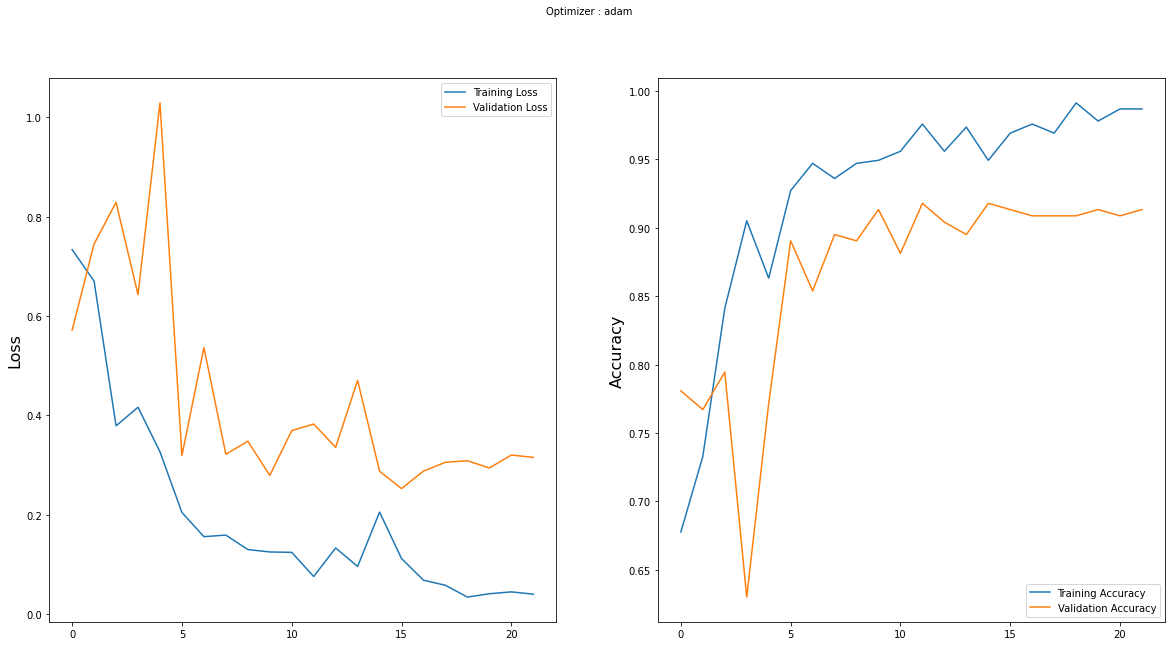

In [55]:
import matplotlib.pyplot as plt

x=hist1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# VGG19

In [56]:
base_model = VGG19(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

x1= Flatten()(base_model.output)
prediction1 = Dense(2, activation='softmax')(x1)
model2 = Model(inputs = base_model.inputs, outputs = prediction1)
model2.summary()
model2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [57]:
hist2 = model2.fit(train_set, validation_data=test_set, epochs=25, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/25
227/227 [==============================] - 54s 234ms/step - loss: 26.5001 - accuracy: 0.4989 - f1_m: 0.5000 - precision_m: 0.5000 - recall_m: 0.5000 - val_loss: 1.6135 - val_accuracy: 0.4566 - val_f1_m: 0.4545 - val_precision_m: 0.4545 - val_recall_m: 0.4545
Epoch 2/25
227/227 [==============================] - 53s 232ms/step - loss: 0.7083 - accuracy: 0.5033 - f1_m: 0.5022 - precision_m: 0.5022 - recall_m: 0.5022 - val_loss: 0.6943 - val_accuracy: 0.4566 - val_f1_m: 0.4545 - val_precision_m: 0.4545 - val_recall_m: 0.4545
Epoch 3/25
227/227 [==============================] - 53s 233ms/step - loss: 0.6911 - accuracy: 0.5519 - f1_m: 0.5529 - precision_m: 0.5529 - recall_m: 0.5529 - val_loss: 0.6972 - val_accuracy: 0.4566 - val_f1_m: 0.4545 - val_precision_m: 0.4545 - val_recall_m: 0.4545609 - f1_m: 0.5621 - precision_m: 0.5621 - recall_ - ETA: 
Epoch 4/25
227/227 [==============================] - 53s 234ms/step - loss: 0.6896 - accuracy: 0.5519 - f1_m: 0.5529 - precision_m: 0

In [67]:
dl_acc = hist2.history["val_accuracy"][10] * 100
dl_prec = hist2.history["val_precision_m"][10] * 100
dl_rec = hist2.history["val_recall_m"][10] * 100
dl_f1 = hist2.history["val_f1_m"][10] * 100

storeResults('VGG19',dl_acc,dl_prec,dl_rec,dl_f1)

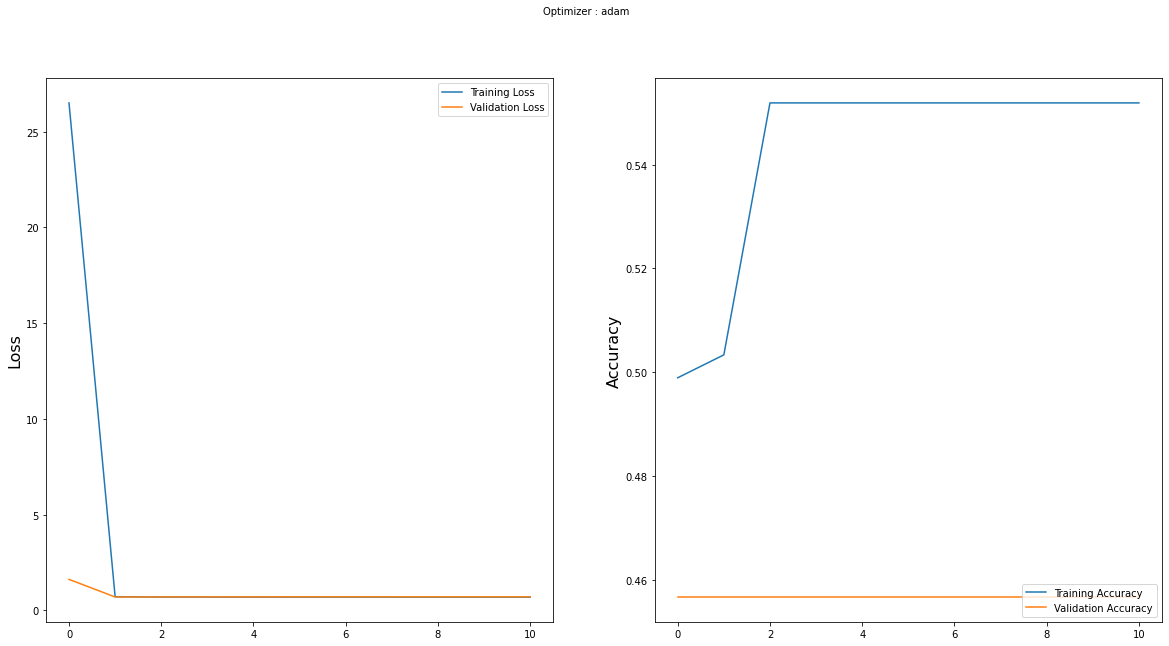

In [58]:
import matplotlib.pyplot as plt

x=hist2
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# ResNet101

In [59]:
base_model = ResNet101(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

x1= Flatten()(base_model.output)
prediction1 = Dense(2, activation='softmax')(x1)
model3 = Model(inputs = base_model.inputs, outputs = prediction1)
model3.summary()
model3.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [60]:
hist3 = model3.fit(train_set, validation_data=test_set, epochs=25, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/25
227/227 [==============================] - 188s 801ms/step - loss: 3.9221 - accuracy: 0.5673 - f1_m: 0.5683 - precision_m: 0.5683 - recall_m: 0.5683 - val_loss: 203.3834 - val_accuracy: 0.4566 - val_f1_m: 0.4591 - val_precision_m: 0.4591 - val_recall_m: 0.4591
Epoch 2/25
227/227 [==============================] - 192s 844ms/step - loss: 0.9918 - accuracy: 0.6755 - f1_m: 0.6762 - precision_m: 0.6762 - recall_m: 0.6762 - val_loss: 33.3460 - val_accuracy: 0.5160 - val_f1_m: 0.5136 - val_precision_m: 0.5136 - val_recall_m: 0.5136
Epoch 3/25
227/227 [==============================] - 192s 845ms/step - loss: 0.8755 - accuracy: 0.7174 - f1_m: 0.7181 - precision_m: 0.7181 - recall_m: 0.7181 - val_loss: 0.7082 - val_accuracy: 0.4566 - val_f1_m: 0.4591 - val_precision_m: 0.4591 - val_recall_m: 0.4591
Epoch 4/25
227/227 [==============================] - 189s 835ms/step - loss: 0.7565 - accuracy: 0.7461 - f1_m: 0.7467 - precision_m: 0.7467 - recall_m: 0.7467 - val_loss: 16946.2480 - va

In [68]:
dl_acc = hist3.history["val_accuracy"][21] * 100
dl_prec = hist3.history["val_precision_m"][21] * 100
dl_rec = hist3.history["val_recall_m"][21] * 100
dl_f1 = hist3.history["val_f1_m"][21] * 100

storeResults('ResNet101',dl_acc,dl_prec,dl_rec,dl_f1)

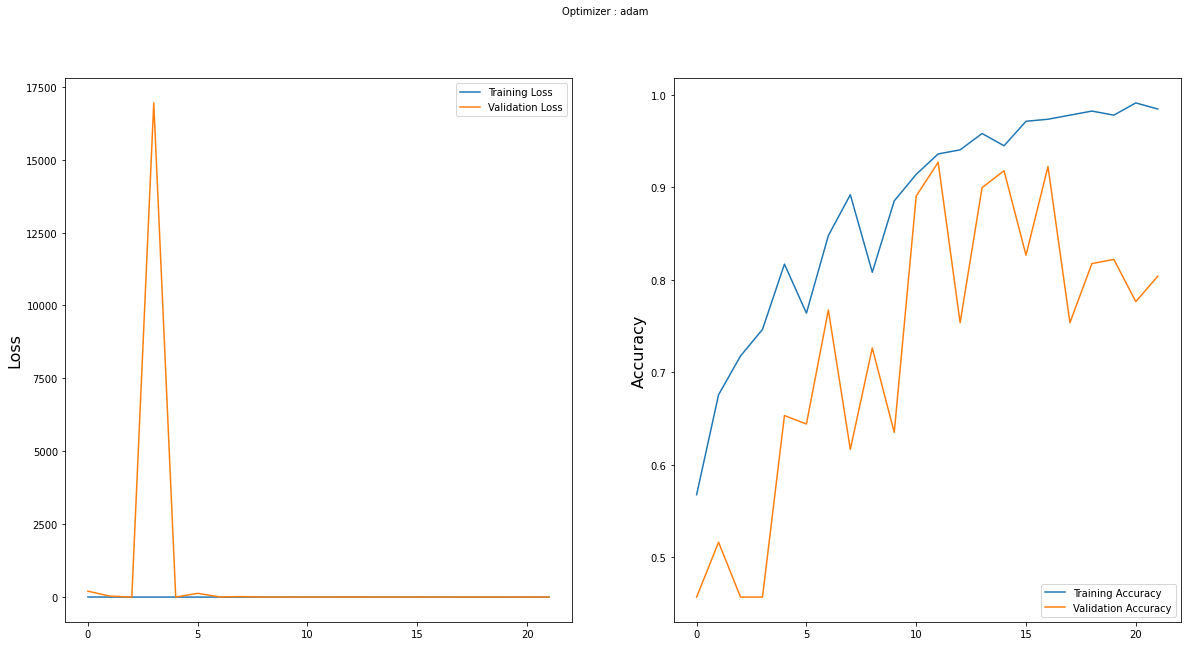

In [61]:
import matplotlib.pyplot as plt

x=hist3
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# DenseNet121

In [62]:
base_model = DenseNet121(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

x1= Flatten()(base_model.output)
prediction1 = Dense(2, activation='softmax')(x1)
model4 = Model(inputs = base_model.inputs, outputs = prediction1)
model4.summary()
model4.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 134, 134, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [63]:
hist4 = model4.fit(train_set, validation_data=test_set, epochs=25, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/25
227/227 [==============================] - 35s 125ms/step - loss: 4.4770 - accuracy: 0.6490 - f1_m: 0.6476 - precision_m: 0.6476 - recall_m: 0.6476 - val_loss: 50.9707 - val_accuracy: 0.5342 - val_f1_m: 0.5364 - val_precision_m: 0.5364 - val_recall_m: 0.5364
Epoch 2/25
227/227 [==============================] - 28s 124ms/step - loss: 4.2889 - accuracy: 0.6887 - f1_m: 0.6872 - precision_m: 0.6872 - recall_m: 0.6872 - val_loss: 84.9576 - val_accuracy: 0.5388 - val_f1_m: 0.5409 - val_precision_m: 0.5409 - val_recall_m: 0.5409
Epoch 3/25
227/227 [==============================] - 29s 127ms/step - loss: 3.3083 - accuracy: 0.7373 - f1_m: 0.7379 - precision_m: 0.7379 - recall_m: 0.7379 - val_loss: 21.2883 - val_accuracy: 0.7215 - val_f1_m: 0.7227 - val_precision_m: 0.7227 - val_recall_m: 0.7227
Epoch 4/25
227/227 [==============================] - 28s 124ms/step - loss: 1.4164 - accuracy: 0.8124 - f1_m: 0.8128 - precision_m: 0.8128 - recall_m: 0.8128 - val_loss: 12.9200 - val_accur

In [69]:
dl_acc = hist4.history["val_accuracy"][24] * 100
dl_prec = hist4.history["val_precision_m"][24] * 100
dl_rec = hist4.history["val_recall_m"][24] * 100
dl_f1 = hist4.history["val_f1_m"][24] * 100

storeResults('DenseNet121',dl_acc,dl_prec,dl_rec,dl_f1)

In [44]:
model4.save('dense_bin.h5')

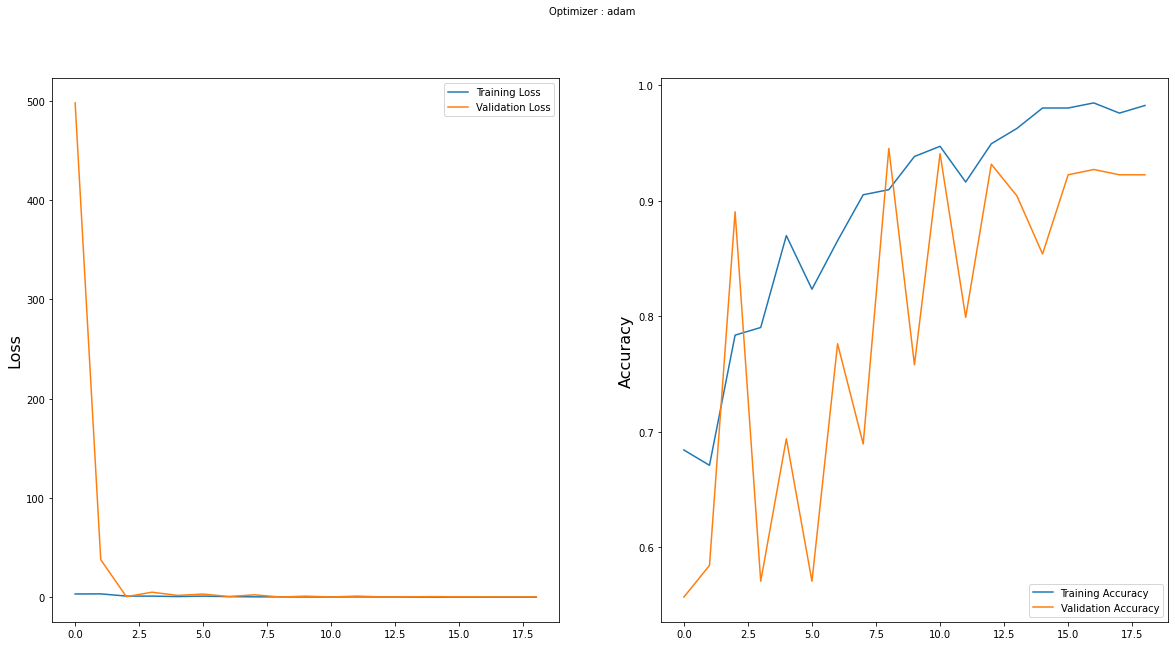

In [31]:
import matplotlib.pyplot as plt

x=hist4
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Xception

In [32]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

In [33]:
# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(2, activation='softmax')(x)
# Combining base and head 
model5 = Model(inputs=base.input, outputs=head)

In [34]:
model5.compile(optimizer='sgd', 
              loss = 'categorical_crossentropy', 
              metrics=["accuracy",f1_m,precision_m, recall_m])

In [35]:
model5.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [41]:
hist5 = model5.fit(train_set, validation_data=test_set, epochs=25, steps_per_epoch=len(train_set), validation_steps=len(test_set))#,callbacks=[learning_rate_reduction, early_stop])

Epoch 1/25
227/227 [==============================] - 120s 528ms/step - loss: 0.0158 - accuracy: 0.9978 - f1_m: 0.9978 - precision_m: 0.9978 - recall_m: 0.9978 - val_loss: 0.1517 - val_accuracy: 0.9498 - val_f1_m: 0.9500 - val_precision_m: 0.9500 - val_recall_m: 0.9500
Epoch 2/25
227/227 [==============================] - 115s 506ms/step - loss: 0.0201 - accuracy: 0.9978 - f1_m: 0.9978 - precision_m: 0.9978 - recall_m: 0.9978 - val_loss: 0.1551 - val_accuracy: 0.9498 - val_f1_m: 0.9500 - val_precision_m: 0.9500 - val_recall_m: 0.9500
Epoch 3/25
227/227 [==============================] - 108s 476ms/step - loss: 0.0190 - accuracy: 0.9978 - f1_m: 0.9978 - precision_m: 0.9978 - recall_m: 0.9978 - val_loss: 0.1622 - val_accuracy: 0.9315 - val_f1_m: 0.9318 - val_precision_m: 0.9318 - val_recall_m: 0.9318
Epoch 4/25
227/227 [==============================] - 112s 494ms/step - loss: 0.0250 - accuracy: 0.9890 - f1_m: 0.9890 - precision_m: 0.9890 - recall_m: 0.9890 - val_loss: 0.1553 - val_accur

In [70]:
dl_acc = hist5.history["val_accuracy"][24] * 100
dl_prec = hist5.history["val_precision_m"][24] * 100
dl_rec = hist5.history["val_recall_m"][24] * 100
dl_f1 = hist5.history["val_f1_m"][24] * 100

storeResults('Xception',dl_acc,dl_prec,dl_rec,dl_f1)

In [43]:
model5.save('xcept_bin.h5')

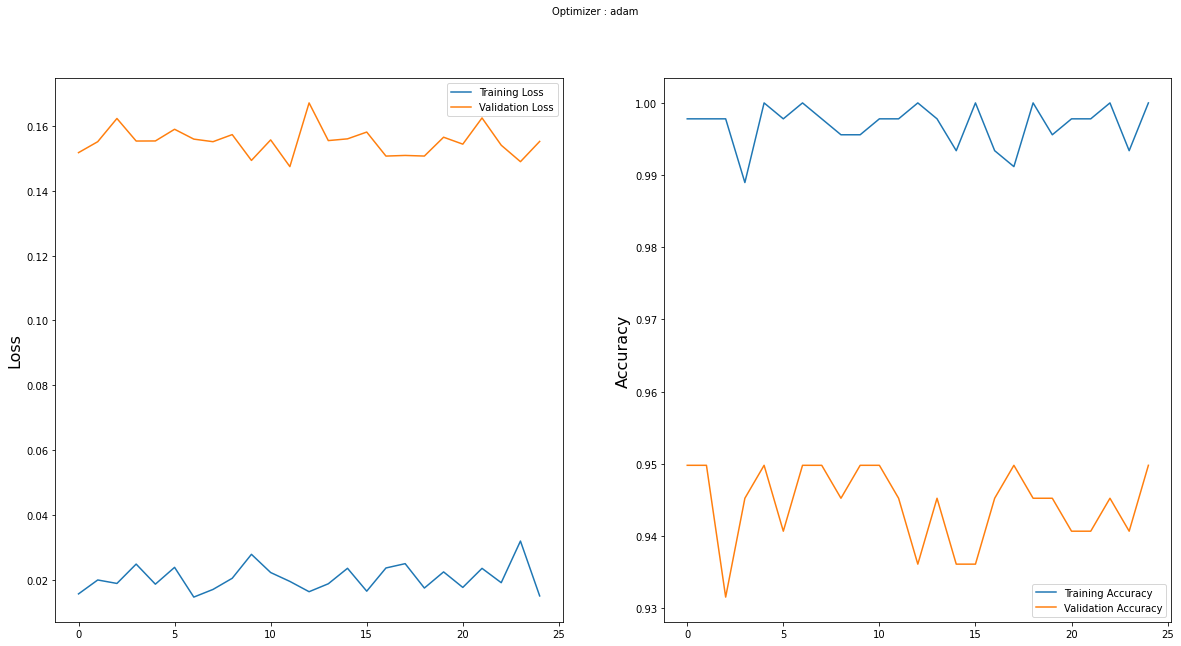

In [42]:
import matplotlib.pyplot as plt

x=hist5
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Hybrid Model

In [45]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Average
import efficientnet.keras 
def ensemble():

    model_1 = load_model('xcept_bin.h5', compile=False)
    model_1 = Model(inputs = model_1.inputs, outputs = model_1.outputs, name = 'Xception')

    model_2 = load_model('dense_bin.h5', compile=False)
    model_2 = Model(inputs = model_2.inputs, outputs = model_2.outputs, name = 'DenseNet')
    
    models = [model_1, model_2]


    models_input = Input(shape =(128,128,3))
    models_output = [model(models_input) for model in models]
    
    ensemble_output = Average()(models_output)

    simple_average = Model(inputs = models_input, outputs = ensemble_output, name = 'Ensemble')

    return simple_average

In [46]:
model = ensemble()
model.compile(optimizer='sgd', 
              loss = 'categorical_crossentropy', 
              metrics=["accuracy",f1_m,precision_m, recall_m])
model.summary()

Model: "Ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Xception (Functional)           (None, 2)            20865578    input_7[0][0]                    
__________________________________________________________________________________________________
DenseNet (Functional)           (None, 2)            7070274     input_7[0][0]                    
__________________________________________________________________________________________________
average (Average)               (None, 2)            0           Xception[0][0]                   
                                                                 DenseNet[0][0]            

In [78]:
history = model.fit(
    train_set,
    epochs=25,
    validation_data=test_set)#,callbacks=[learning_rate_reduction, early_stop])

Epoch 1/25
110/110 [==============================] - 57s 518ms/step - loss: 0.1010 - accuracy: 0.8813 - f1_m: 0.8773 - precision_m: 0.8773 - recall_m: 0.8773 - val_loss: 0.0408 - val_accuracy: 0.9772 - val_f1_m: 0.9773 - val_precision_m: 0.9773 - val_recall_m: 0.9773
Epoch 2/25
110/110 [==============================] - 60s 549ms/step - loss: 0.1075 - accuracy: 0.8721 - f1_m: 0.8727 - precision_m: 0.8727 - recall_m: 0.8727 - val_loss: 0.0462 - val_accuracy: 0.9726 - val_f1_m: 0.9727 - val_precision_m: 0.9727 - val_recall_m: 0.9727
Epoch 3/25
110/110 [==============================] - 48s 435ms/step - loss: 0.0916 - accuracy: 0.8858 - f1_m: 0.8818 - precision_m: 0.8818 - recall_m: 0.8818 - val_loss: 0.0471 - val_accuracy: 0.9817 - val_f1_m: 0.9818 - val_precision_m: 0.9818 - val_recall_m: 0.9818
Epoch 4/25
110/110 [==============================] - 60s 552ms/step - loss: 0.1078 - accuracy: 0.8676 - f1_m: 0.8682 - precision_m: 0.8682 - recall_m: 0.8682 - val_loss: 0.0470 - val_accuracy:

In [72]:
dl_acc = history.history["val_accuracy"][24] * 100
dl_prec = history.history["val_precision_m"][24] * 100
dl_rec = history.history["val_recall_m"][24] * 100
dl_f1 = history.history["val_f1_m"][24] * 100

storeResults('Hybrid Model',dl_acc,dl_prec,dl_rec,dl_f1)

In [73]:
model.save('model_bin.h5')

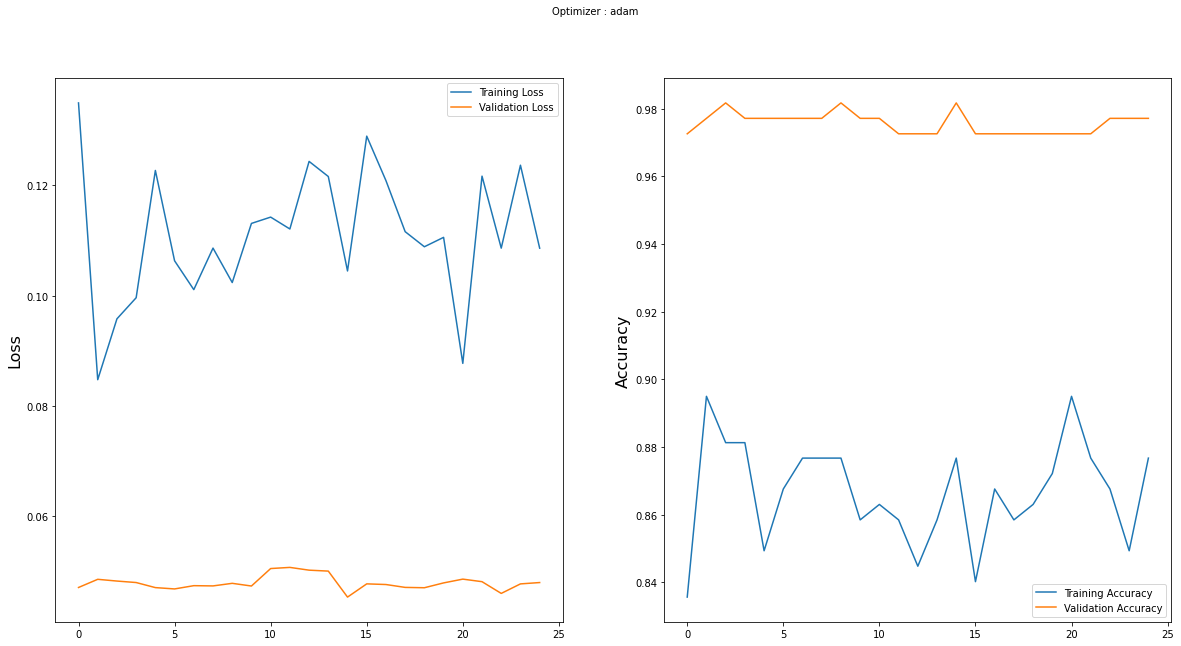

In [74]:
import matplotlib.pyplot as plt

x=history
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Comparison

In [75]:
#creating dataframe
import pandas as pd
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                       'Precision': precision,
                       'Recall'   : recall, 
                       'F1_score' : f1score                        
                      })

In [76]:
result

,ML Model,Accuracy,Precision,Recall,F1_score
0,ResCapsNet,99.090,99.160,99.160,99.160
1,CNN,91.324,91.364,91.364,91.364
2,VGG19,45.662,45.455,45.455,45.455
3,ResNet101,80.365,80.000,80.000,80.000
4,DenseNet121,91.781,91.818,91.818,91.818
5,Xception,94.977,95.000,95.000,95.000
6,Hybrid Model,97.717,97.727,97.727,97.727


# Graph

In [79]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

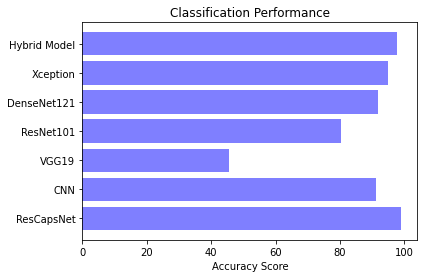

In [80]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

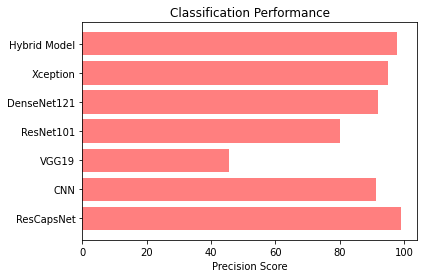

In [81]:
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

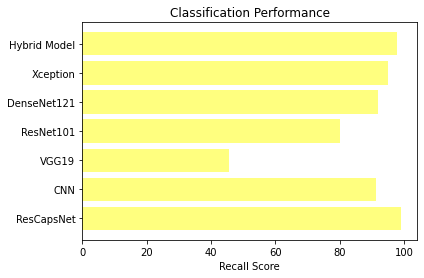

In [82]:
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

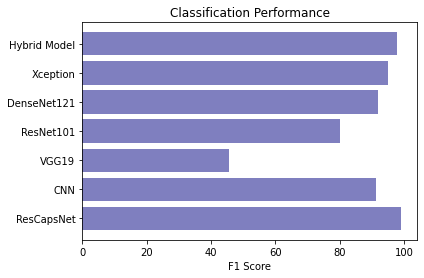

In [83]:
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='navy')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()